In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [15]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.identity_mapping = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.identity_mapping = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.identity_mapping(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + identity
        x = self.relu(x)
        return x

In [23]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=200, blocks=[3, 4, 6, 3]):
        super(ResNet34, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self.make_layer(in_channels=64, out_channels=64, num_blocks=blocks[0], stride=1)
        self.layer2 = self.make_layer(in_channels=64, out_channels=128, num_blocks=blocks[1], stride=2)
        self.layer3 = self.make_layer(in_channels=128, out_channels=256, num_blocks=blocks[2], stride=2)
        self.layer4 = self.make_layer(in_channels=256, out_channels=512, num_blocks=blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(Block(in_channels, out_channels, stride))  # Downsampling block
        for _ in range(1, num_blocks):
            layers.append(Block(out_channels, out_channels))  # Identity blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [13]:
from scripts.cv_utils import *

In [5]:
transform = cifar_transform()
train_loader, test_loader = download_cifar100(transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
# hyperparameters
n_epochs = 2
save_checkpoint = 1
num_classes = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device for training:", device)
print("#" * 20)

model = ResNet34(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model.to(device)
epoch_loss_history = []
batch_loss_history = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    
    for idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # loss update
        running_loss += loss.item()
    
        if idx % 100 == 0 and idx != 0:
            batch_loss = running_loss/idx
            batch_loss_history.append(batch_loss)
            print(f"Epoch {epoch+1}/{n_epochs} - Step {idx}: Loss {batch_loss:4f}")

    # save checkpoint
    if epoch % save_checkpoint == 0:
        torch.save(model.state_dict(), f"models/test/checkpoint_{(epoch) / save_checkpoint}.pth")
    
    train_loss = running_loss / len(train_loader) 
    epoch_loss_history.append(train_loss)
    batch_loss_history.append(batch_loss)
    print(f"Final Eval - Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}")
    print("#" * 20)

torch.save(model.state_dict(), f"models/test/checkpoint_final.pth")

Current device for training: cuda
####################
Epoch 1/2 - Step 100: Loss 4.552824
Epoch 1/2 - Step 200: Loss 4.356210
Epoch 1/2 - Step 300: Loss 4.225033
Epoch 1/2 - Step 400: Loss 4.122031
Epoch 1/2 - Step 500: Loss 4.033115
Epoch 1/2 - Step 600: Loss 3.950240
Epoch 1/2 - Step 700: Loss 3.873485
Final Eval - Epoch 1/2 - Train Loss: 3.8158
####################
Epoch 2/2 - Step 100: Loss 3.202990
Epoch 2/2 - Step 200: Loss 3.161355
Epoch 2/2 - Step 300: Loss 3.118629
Epoch 2/2 - Step 400: Loss 3.072603
Epoch 2/2 - Step 500: Loss 3.029414
Epoch 2/2 - Step 600: Loss 2.993579
Epoch 2/2 - Step 700: Loss 2.953631
Final Eval - Epoch 2/2 - Train Loss: 2.9174
####################


In [52]:
import numpy as np

loss = np.array(batch_loss_history)
loss.shape

(16,)

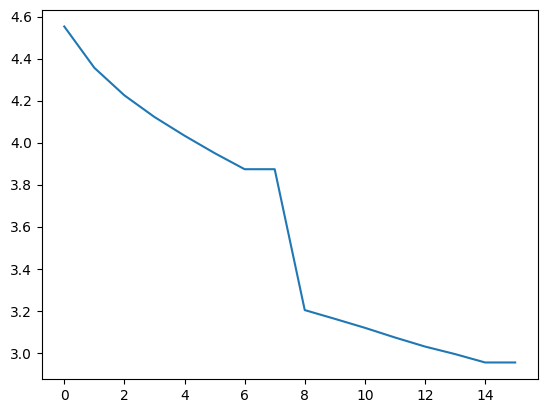

In [53]:
import matplotlib.pyplot as plt

plt.plot(loss)

In [41]:
np.array(batch_loss).shape

(782,)

In [50]:
torch.save(model.state_dict(), "/models/test.test.pth")

RuntimeError: Parent directory /models does not exist.

In [54]:
epoch_loss_history

[3.815817240254044, 2.9174326828983435]